In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from google.colab import files


In [2]:
print("开始上传文件...")
uploaded = files.upload()

if uploaded:
    file_name = list(uploaded.keys())[0]
    print(f"已上传文件: {file_name}")

    # 读取数据
    data = pd.read_csv(file_name)
    print("数据加载完成。")
    print(f"原始数据形状: {data.shape}")
    print("\n数据前5行:")
    print(data.head())
else:
    print("没有上传文件，程序终止。")


开始上传文件...


Saving Real_Price_Electricity_Data_new.csv to Real_Price_Electricity_Data_new.csv
已上传文件: Real_Price_Electricity_Data_new.csv
数据加载完成。
原始数据形状: (82343, 6)

数据前5行:
            Date   Demand      Price  Renewable_Share  Total_Generation  \
0  2015/1/1 0:00  26.9405  37.567164              NaN          0.000000   
1  2015/1/1 1:00  27.1655  32.437811             1.44          2.221583   
2  2015/1/1 2:00  24.4715  30.124378             3.20          4.766902   
3  2015/1/1 3:00  23.0030  25.855721             3.38          4.932767   
4  2015/1/1 4:00  21.8320  25.412935             3.54          5.085311   

   Load_Ratio  
0         inf  
1   12.227992  
2    5.133628  
3    4.663306  
4    4.293149  


In [3]:
def preprocess_data(data):
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    columns = ['Demand', 'Renewable_Share', 'Price', 'Total_Generation', 'Load_Ratio']
    for col in columns:
        if col not in data.columns:
            raise ValueError(f"Column '{col}' is not in the data")
    data = data[columns]


    data = data.replace([np.inf, -np.inf], np.nan)


    nan_count = data.isna().sum()
    print("Number of NaN values in each column:")
    print(nan_count)


    data = data.fillna(method='ffill').fillna(method='bfill')


    data = data.dropna()

    print("Shape of the cleaned data:", data.shape)
    return data

# Preprocess data
try:
    processed_data = preprocess_data(data)
    print("Data preprocessing completed.")
except ValueError as e:
    print(f"Preprocessing error: {str(e)}")



Number of NaN values in each column:
Demand                0
Renewable_Share      61
Price               152
Total_Generation      0
Load_Ratio           61
dtype: int64
Shape of the cleaned data: (82343, 5)
Data preprocessing completed.


<ipython-input-3-b5facaa1c54d>:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(method='bfill')


In [4]:
def normalize_data(data):
    robust_scaler = RobustScaler()
    robust_scaled = robust_scaler.fit_transform(data)

    minmax_scaler = MinMaxScaler()
    normalized_data = minmax_scaler.fit_transform(robust_scaled)

    print("Range of normalized data:")
    for i, col in enumerate(data.columns):
        print(f"{col}: {normalized_data[:, i].min():.4f} to {normalized_data[:, i].max():.4f}")

    class CombinedScaler:
        def __init__(self, robust, minmax):
            self.robust = robust
            self.minmax = minmax

        def inverse_transform(self, data):
            return self.robust.inverse_transform(self.minmax.inverse_transform(data))

    combined_scaler = CombinedScaler(robust_scaler, minmax_scaler)
    return normalized_data, combined_scaler

normalized_data, scaler = normalize_data(processed_data)
print("Data normalization completed.")



Range of normalized data:
Demand: 0.0000 to 1.0000
Renewable_Share: 0.0000 to 1.0000
Price: 0.0000 to 1.0000
Total_Generation: 0.0000 to 1.0000
Load_Ratio: 0.0000 to 1.0000
Data normalization completed.


In [5]:
def create_sequences(data, seq_length):
    X, y = [], []  # Correctly initialize two separate lists
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length, 2])  # 2 is the index for the Price column
    return np.array(X), np.array(y)

seq_length = 168  # Number of hours in a week
X, y = create_sequences(normalized_data, seq_length)
print(f"Sequence creation completed. X shape: {X.shape}, y shape: {y.shape}")



Sequence creation completed. X shape: (82175, 168, 5), y shape: (82175,)


In [6]:
split = int(0.9 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [7]:
def build_model(input_shape):
    model = Sequential([
        LSTM(64, activation='relu', input_shape=input_shape, return_sequences=True),
        LSTM(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# 构建和训练模型
model = build_model((seq_length, X.shape[2]))
print("开始训练模型...")
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)
print("模型训练完成。")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


开始训练模型...
Epoch 1/100
1849/1849 ━━━━━━━━━━━━━━━━━━━━ 209s 112ms/step - loss: 2.4068e-04 - val_loss: 0.0016
Epoch 2/100
1849/1849 ━━━━━━━━━━━━━━━━━━━━ 206s 111ms/step - loss: 1.4199e-04 - val_loss: 3.8394e-04
Epoch 3/100
1849/1849 ━━━━━━━━━━━━━━━━━━━━ 203s 110ms/step - loss: 1.0865e-04 - val_loss: 6.6060e-04
Epoch 4/100
1849/1849 ━━━━━━━━━━━━━━━━━━━━ 208s 112ms/step - loss: 9.1654e-05 - val_loss: 2.9000e-04
Epoch 5/100
1849/1849 ━━━━━━━━━━━━━━━━━━━━ 208s 112ms/step - loss: 6.5945e-05 - val_loss: 0.0012
Epoch 6/100
1849/1849 ━━━━━━━━━━━━━━━━━━━━ 205s 111ms/step - loss: 9.2575e-05 - val_loss: 3.5639e-04
Epoch 7/100
1849/1849 ━━━━━━━━━━━━━━━━━━━━ 202s 109ms/step - loss: 6.2278e-05 - val_loss: 2.9778e-04
Epoch 8/100
1849/1849 ━━━━━━━━━━━━━━━━━━━━ 207s 112ms/step - loss: 8.8754e-05 - val_loss: 2.4403e-04
Epoch 9/100
1849/1849 ━━━━━━━━━━━━━━━━━━━━ 202s 109ms/step - loss: 6.4504e-05 - val_loss: 2.6000e-04
Epoch 10/100
1849/1849 ━━━━━━━━━━━━━━━━━━━━ 204s 110ms/step - loss: 5.9684e-05 - val_loss

In [8]:
import pickle
from sklearn.preprocessing import RobustScaler, MinMaxScaler

def extract_scalers(combined_scaler):

    robust_scaler = RobustScaler()
    robust_scaler.center_ = combined_scaler.robust.center_
    robust_scaler.scale_ = combined_scaler.robust.scale_


    minmax_scaler = MinMaxScaler()
    minmax_scaler.min_ = combined_scaler.minmax.min_
    minmax_scaler.scale_ = combined_scaler.minmax.scale_

    return robust_scaler, minmax_scaler


robust_scaler, minmax_scaler = extract_scalers(scaler)


model.save('trained_model.keras')
print("模型已保存为 'trained_model.keras'")


with open('robust_scaler.pkl', 'wb') as f:
    pickle.dump(robust_scaler, f)
with open('minmax_scaler.pkl', 'wb') as f:
    pickle.dump(minmax_scaler, f)
print("Scaler已保存为 'robust_scaler.pkl' 和 'minmax_scaler.pkl'")

模型已保存为 'trained_model.keras'
Scaler已保存为 'robust_scaler.pkl' 和 'minmax_scaler.pkl'



评估模型性能:
257/257 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step
MSE: 165.2280
RMSE: 12.8541
MAE: 9.9872
R²: 0.8027


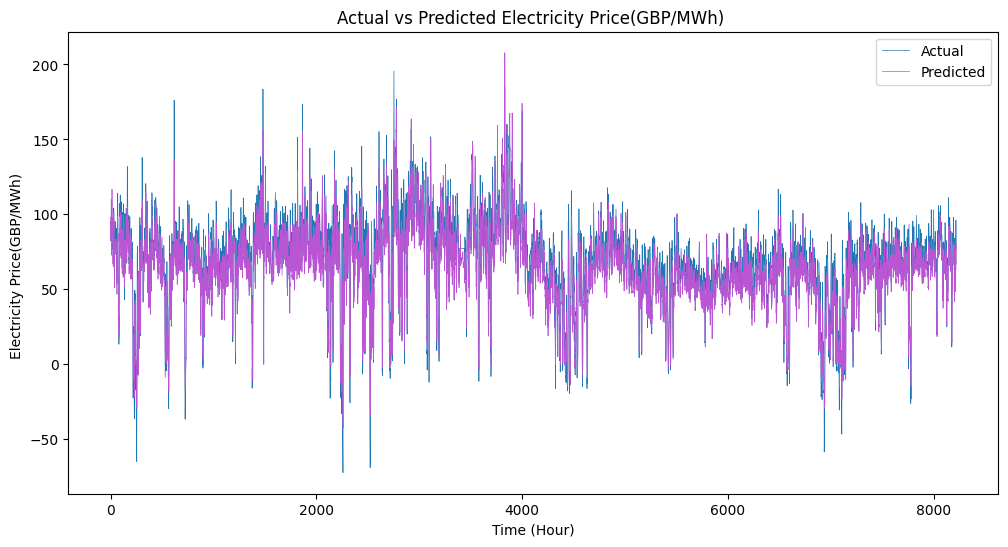

In [9]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")


print("\n评估模型性能:")
y_pred = model.predict(X_test)


y_test_original = scaler.inverse_transform(np.hstack([X_test[:, -1, :2], y_test.reshape(-1, 1), X_test[:, -1, 3:]]))[: ,2]
y_pred_original = scaler.inverse_transform(np.hstack([X_test[:, -1, :2], y_pred, X_test[:, -1, 3:]]))[: ,2]


evaluate_model(y_test_original, y_pred_original)


import matplotlib.pyplot as plt

def plot_predictions(y_true, y_pred, title="Actual vs Predicted"):
    plt.figure(figsize=(12, 6))


    plt.plot(y_true, label='Actual', color='#1f77b4', linewidth=0.5)


    plt.plot(y_pred, label='Predicted', color='#BA55D3', linewidth=0.5)


    plt.title(title)
    plt.xlabel('Time (Hour)')
    plt.ylabel('Electricity Price(GBP/MWh) ')


    plt.legend()


    plt.show()



plot_predictions(y_test_original, y_pred_original, title="Actual vs Predicted Electricity Price(GBP/MWh) ")

In [10]:
# 确定 X_test 对应的时间范围
X_test_time_index = processed_data.index[-len(X_test):]

# 打印预测值对应的时间范围
print(f"预测的时间范围从 {X_test_time_index[0]} 到 {X_test_time_index[-1]}")


预测的时间范围从 2023-06-22 01:00:00 到 2024-05-30 21:00:00


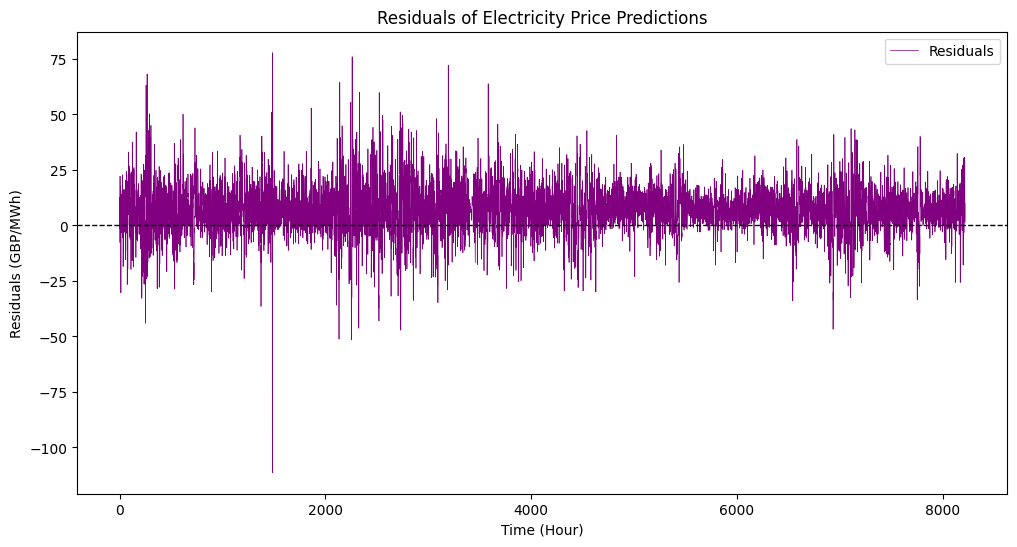

In [11]:
import matplotlib.pyplot as plt


residuals = y_test_original - y_pred_original


def plot_residuals(residuals, title="Residuals Plot"):
    plt.figure(figsize=(12, 6))
    plt.plot(residuals, label='Residuals', color='purple', linewidth=0.5)
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.title(title)
    plt.xlabel('Time (Hour)')
    plt.ylabel('Residuals (GBP/MWh)')
    plt.legend()
    plt.show()


plot_residuals(residuals, title="Residuals of Electricity Price Predictions")


In [ ]:
# 假设负数存在于价格数据中
price_data = processed_data['Price'].values.reshape(-1, 1)

# 使用 MinMaxScaler 进行归一化
minmax_scaler = MinMaxScaler()
price_scaled = minmax_scaler.fit_transform(price_data)

# 打印归一化后的数据范围
print("Price data after MinMaxScaler (with potential negative values):")
print(f"Min: {price_scaled.min()}, Max: {price_scaled.max()}")

# 逆归一化过程
price_restored = minmax_scaler.inverse_transform(price_scaled)
print("Restored price data range after MinMaxScaler inverse:")
print(f"Min: {price_restored.min()}, Max: {price_restored.max()}")


Price data after MinMaxScaler (with potential negative values):
Min: 0.0, Max: 1.0
Restored price data range after MinMaxScaler inverse:
Min: -72.40827846, Max: 1846.948494


In [ ]:
# 打印 MinMaxScaler 的相关属性
print("MinMaxScaler scale_:", scaler.minmax.scale_)
print("MinMaxScaler min_:", scaler.minmax.min_)

# 打印 RobustScaler 的相关属性
print("RobustScaler center_:", scaler.robust.center_)
print("RobustScaler scale_:", scaler.robust.scale_)



MinMaxScaler scale_: [0.08874664 0.02268152 0.02115373 0.01466236 0.00482702]
MinMaxScaler min_: [0.2451394  0.03065426 0.06286199 0.03754913 0.01132009]
RobustScaler center_: [34.182      23.34       48.24630542 60.559137    0.58066568]
RobustScaler scale_: [12.18975    17.24       40.60155001 23.6474125   0.24732439]


In [ ]:
# 检查 X_new 的形状
print(f"X_new shape: {X_new.shape}")


X_new shape: (8593, 168, 4)


In [ ]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def build_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(LSTM(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# 假设你的输入形状为 (168, 4)
input_shape = (168, 4)  # 168 是时间步长，4 是特征数
model = build_model(input_shape)



In [ ]:
def generate_typical_year(data):
    # 按 DayOfYear 和 Hour 分组并计算平均值
    typical_year = data.groupby([data.index.dayofyear, data.index.hour]).mean()

    # 将索引重命名为 DayOfYear 和 Hour
    typical_year.index.names = ['DayOfYear', 'Hour']

    return typical_year

# 使用多年的数据生成典型年的电价曲线
typical_year = generate_typical_year(processed_data)
print("典型年数据前几行:")
print(typical_year.head())


典型年数据前几行:
                  Demand  Renewable_Share      Price  Total_Generation  \
DayOfYear Hour                                                           
1         0     29.20760           30.645  46.487139         59.689715   
          1     28.37610           32.114  45.058643         61.595322   
          2     25.68975           35.841  38.122439         64.633460   
          3     23.54255           39.053  25.266195         67.322092   
          4     22.18660           40.883  22.951551         68.438361   

                Load_Ratio  DayOfYear  Hour  
DayOfYear Hour                               
1         0       1.641200        1.0   0.0  
          1       1.623963        1.0   1.0  
          2       0.876705        1.0   2.0  
          3       0.792347        1.0   3.0  
          4       0.734297        1.0   4.0  


In [ ]:
import tensorflow as tf
import pickle
from sklearn.preprocessing import RobustScaler, MinMaxScaler

# 加载训练好的模型
model = tf.keras.models.load_model('trained_model.keras')

# 加载保存的 Scaler 对象
with open('robust_scaler.pkl', 'rb') as f:
    robust_scaler = pickle.load(f)

with open('minmax_scaler.pkl', 'rb') as f:
    minmax_scaler = pickle.load(f)

print("模型和Scaler加载完成。")


模型和Scaler加载完成。


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
full_data= typical_year[['DayOfYear','Hour','Demand', 'Renewable_Share', 'Total_Generation', 'Load_Ratio']].values



print("预测数据准备完成，前5行:")
print(full_data[:5])

预测数据准备完成，前5行:
[[ 1.          0.         29.2076     30.645      59.6897152   1.6411997 ]
 [ 1.          1.         28.3761     32.114      61.5953217   1.62396302]
 [ 1.          2.         25.68975    35.841      64.6334605   0.87670497]
 [ 1.          3.         23.54255    39.053      67.3220922   0.79234656]
 [ 1.          4.         22.1866     40.883      68.4383605   0.73429715]]


In [ ]:
import pandas as pd

# 假设 full_data 只有 6 列
# 调整列名以匹配 full_data 的列数
column_names = ['DayOfYear', 'Hour', 'Demand', 'Renewable_Share', 'Total_Generation', 'Load_Ratio']

# 将 full_data 转换为 DataFrame
full_data_df = pd.DataFrame(full_data, columns=column_names)

# 查看 DataFrame 的列名和前几行数据
print("full_data 的列名:")
print(full_data_df.columns)

print("\nfull_data 的前5行数据:")
print(full_data_df.head())



full_data 的列名:
Index(['DayOfYear', 'Hour', 'Demand', 'Renewable_Share', 'Total_Generation',
       'Load_Ratio'],
      dtype='object')

full_data 的前5行数据:
   DayOfYear  Hour    Demand  Renewable_Share  Total_Generation  Load_Ratio
0        1.0   0.0  29.20760           30.645         59.689715    1.641200
1        1.0   1.0  28.37610           32.114         61.595322    1.623963
2        1.0   2.0  25.68975           35.841         64.633460    0.876705
3        1.0   3.0  23.54255           39.053         67.322092    0.792347
4        1.0   4.0  22.18660           40.883         68.438361    0.734297


In [ ]:
import numpy as np
def inverse_transform_price(scaler_X, scaler_y, X, y):
    # 将 y (预测的价格) 添加到 X 数据的最后一列
    X_with_price = np.hstack([X, y])

    # 首先恢复 MinMaxScaler 的影响
    minmax_restored = scaler_y.inverse_transform(X_with_price)

    # 然后恢复 RobustScaler 的影响
    robust_restored = scaler_X.inverse_transform(minmax_restored)

    # 返回最终的价格列
    return robust_restored[:, -1]  # 最后一列是恢复后的价格
def predict(model, data, scaler_X, scaler_y, seq_length=168):
    # 排除 DayOfYear 和 Hour 列，保留用于预测的特征列
    input_data = data[:, 2:]  # 提取 Demand, Renewable_Share, Total_Generation, Load_Ratio 列

    # 进行归一化处理
    input_data_with_price = np.column_stack([input_data, np.zeros((input_data.shape[0], 1))])  # 添加 Price 列占位符
    normalized_data = scaler_X.transform(input_data_with_price)
    normalized_data = np.delete(normalized_data, -1, axis=1)  # 删除虚拟的 Price 列

    # 初始化输入序列
    initial_sequence = normalized_data[:seq_length].reshape(1, seq_length, -1)
    predicted_prices = []

    for i in range(seq_length, len(normalized_data)):
        prediction = model.predict_on_batch(initial_sequence)
        predicted_price = prediction[0, 0]  # 预测值

        predicted_prices.append(predicted_price)

        # 更新序列，用当前的预测值和实际的自变量值继续预测
        new_row = normalized_data[i]
        initial_sequence = np.roll(initial_sequence, -1, axis=1)
        initial_sequence[0, -1, :] = new_row

    predicted_prices = np.array(predicted_prices).reshape(-1, 1)

    # 反归一化价格
    predicted_prices = inverse_transform_price(scaler_X, scaler_y, normalized_data[seq_length:], predicted_prices)

    return predicted_prices.flatten()

# 使用上面定义的函数进行电价预测
predicted_prices = predict(model, full_data, robust_scaler, minmax_scaler)

# 查看预测结果的前5个值
print("预测价格 (前5个小时):", predicted_prices[:5])


预测价格 (前5个小时): [2.10255905 2.72204363 3.43458616 4.2001242  4.90152845]


In [ ]:
def predict_and_check(model, data, scaler_X, scaler_y, seq_length=168):
    # 排除 DayOfYear 和 Hour 列，保留用于预测的特征列
    input_data = data[:, 2:]  # 提取 Demand, Renewable_Share, Total_Generation, Load_Ratio 列

    # 进行归一化处理
    input_data_with_price = np.column_stack([input_data, np.zeros((input_data.shape[0], 1))])  # 添加 Price 列占位符
    normalized_data = scaler_X.transform(input_data_with_price)
    normalized_data = np.delete(normalized_data, -1, axis=1)  # 删除虚拟的 Price 列

    # 初始化输入序列
    initial_sequence = normalized_data[:seq_length].reshape(1, seq_length, -1)
    predicted_prices = []

    for i in range(seq_length, len(normalized_data)):
        prediction = model.predict_on_batch(initial_sequence)
        predicted_price = prediction[0, 0]  # 预测值

        predicted_prices.append(predicted_price)

        # 更新序列，用当前的预测值和实际的自变量值继续预测
        new_row = normalized_data[i]
        initial_sequence = np.roll(initial_sequence, -1, axis=1)
        initial_sequence[0, -1, :] = new_row

    predicted_prices = np.array(predicted_prices).reshape(-1, 1)

    # 输出未经反归一化的预测结果
    print("未经反归一化的预测价格 (前5个小时):", predicted_prices[:5].flatten())

    # 反归一化价格
    predicted_prices = inverse_transform_price(scaler_X, scaler_y, normalized_data[seq_length:], predicted_prices)

    return predicted_prices.flatten()

# 使用上面定义的函数进行电价预测并检查
predicted_prices = predict_and_check(model, full_data, robust_scaler, minmax_scaler)

# 查看最终反归一化后的预测结果
print("反归一化后的预测价格 (前5个小时):", predicted_prices[:5])


未经反归一化的预测价格 (前5个小时): [0.04102284 0.0531133  0.06701998 0.08196096 0.09565025]
反归一化后的预测价格 (前5个小时): [2.10255905 2.72204363 3.43458616 4.2001242  4.90152845]


In [ ]:
import numpy as np

# 添加一个占位符列（例如全零列），以匹配 scaler 的期望输入形状
input_data_with_placeholder = np.column_stack([full_data[:, 2:], np.zeros((full_data.shape[0], 1))])

# 归一化处理
normalized_data = robust_scaler.transform(input_data_with_placeholder)
normalized_data = minmax_scaler.transform(normalized_data)

# 删除最后一列（虚拟的 Price 列），返回归一化后的有效数据
normalized_data = normalized_data[:, :-1]

# 查看归一化后的数据分布
print("归一化后的数据分布 (前5行):")
print(normalized_data[:5])



归一化后的数据分布 (前5行):
[[0.20892362 0.04026497 0.0688241  0.00101761]
 [0.20286995 0.04219763 0.06981693 0.00100692]
 [0.18331216 0.047101   0.07139983 0.00054359]
 [0.16767962 0.05132682 0.07280062 0.00049129]
 [0.15780772 0.05373443 0.07338221 0.00045529]]


In [ ]:
def predict(model, data, scaler_X, scaler_y, seq_length=168):
    # 排除 DayOfYear 和 Hour 列，保留用于预测的特征列
    input_data = data[:, 2:]  # 提取 Demand, Renewable_Share, Total_Generation, Load_Ratio 列

    # 检查输入数据的形状和前几行
    print("输入数据形状:", input_data.shape)
    print("输入数据 (前5行):")
    print(input_data[:5])

    # 进行归一化处理
    input_data_with_price = np.column_stack([input_data, np.zeros((input_data.shape[0], 1))])  # 添加 Price 列占位符
    normalized_data = scaler_X.transform(input_data_with_price)
    normalized_data = np.delete(normalized_data, -1, axis=1)  # 删除虚拟的 Price 列

    # 初始化输入序列
    initial_sequence = normalized_data[:seq_length].reshape(1, seq_length, -1)
    predicted_prices = []

    for i in range(seq_length, len(normalized_data)):
        prediction = model.predict_on_batch(initial_sequence)
        predicted_price = prediction[0, 0]  # 预测值

        predicted_prices.append(predicted_price)

        # 更新序列，用当前的预测值和实际的自变量值继续预测
        new_row = normalized_data[i]
        initial_sequence = np.roll(initial_sequence, -1, axis=1)
        initial_sequence[0, -1, :] = new_row

    predicted_prices = np.array(predicted_prices).reshape(-1, 1)

    # 调用反归一化函数之前，检查预测值
    print("预测值 (前5个):", predicted_prices[:5])

    # 反归一化价格
    predicted_prices = inverse_transform_price(scaler_X, scaler_y, normalized_data[seq_length:], predicted_prices)

    return predicted_prices.flatten()

# 使用上面定义的函数进行电价预测
predicted_prices = predict(model, full_data, robust_scaler, minmax_scaler)

# 查看最终反归一化后的预测结果
print("反归一化后的预测价格 (前5个小时):", predicted_prices[:5])



输入数据形状: (8784, 4)
输入数据 (前5行):
[[29.2076     30.645      59.6897152   1.6411997 ]
 [28.3761     32.114      61.5953217   1.62396302]
 [25.68975    35.841      64.6334605   0.87670497]
 [23.54255    39.053      67.3220922   0.79234656]
 [22.1866     40.883      68.4383605   0.73429715]]
预测值 (前5个): [[0.04102284]
 [0.0531133 ]
 [0.06701998]
 [0.08196096]
 [0.09565025]]
MinMaxScaler 反归一化后的数据 (前5行):
[[  -6.72480364   20.97673149   17.38411464 -175.72828415    6.15343023]
 [  -7.41106771   26.37018669   20.79221744 -175.82126667    8.65817544]
 [  -8.66374921   31.93498447   22.59135291 -175.89354171   11.53917934]
 [  -9.64318225   26.66428216   18.31089259 -175.93260961   14.63445856]
 [ -10.6144807    35.32347576   22.79299352 -175.9983946    17.47042733]]
RobustScaler 反归一化后的数据 (前5行):
[[-4.77916752e+01  3.84978851e+02  7.54068305e+02 -4.09496009e+03
   2.10255905e+00]
 [-5.61570626e+01  4.77962019e+02  8.92442561e+02 -4.09715888e+03
   2.72204363e+00]
 [-7.14269369e+01  5.73899132e+02  9.6

In [ ]:
from sklearn.preprocessing import StandardScaler

# 创建 StandardScaler 实例
scaler_X = StandardScaler()
scaler_y = StandardScaler()


# 对特征和目标进行缩放
train_X_scaled = scaler_X.fit_transform(X_train)
train_y_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))


ValueError: Found array with dim 3. StandardScaler expected <= 2.

In [ ]:
# 将三维数据 (samples, sequence_length, features) 转换为二维数据 (samples * sequence_length, features)
n_samples, sequence_length, n_features = X_train.shape
X_train_reshaped = X_train.reshape(n_samples * sequence_length, n_features)

# 对二维数据进行缩放
X_train_scaled = scaler_X.fit_transform(X_train_reshaped)

# 将数据转换回三维形式
X_train_scaled = X_train_scaled.reshape(n_samples, sequence_length, n_features)

# 对 y_train 进行缩放
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
# 对测试数据进行同样的处理
n_samples_test, sequence_length_test, n_features_test = X_test.shape
X_test_reshaped = X_test.reshape(n_samples_test * sequence_length_test, n_features_test)

# 对测试数据进行缩放
X_test_scaled = scaler_X.transform(X_test_reshaped)

# 将数据转换回三维形式
X_test_scaled = X_test_scaled.reshape(n_samples_test, sequence_length_test, n_features_test)

# 对 y_test 进行缩放
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))



In [ ]:
# 查看模型的输入形状
print("模型输入形状:", model.input_shape)


模型输入形状: (None, 168, 4)


In [ ]:
# 假设 full_data 是原始的完整数据
# 查看 full_data 的列名
print("full_data 的列名:")
print(full_data.columns)

# 确认哪些列是需要保留的
# 例如，假设需要保留的是 'Demand', 'Renewable_Share', 'Total_Generation', 'Load_Ratio'
columns_to_keep = ['Demand', 'Renewable_Share', 'Total_Generation', 'Load_Ratio']

# 确保输入数据只有 4 个特征
# 先检查并保留所需的列
X_train_selected = full_data[columns_to_keep].values.reshape(X_train.shape)  # 重新调整为三维
X_test_selected = full_data[columns_to_keep].values.reshape(X_test.shape)    # 重新调整为三维

# 对选择的列进行缩放
n_samples_train, sequence_length_train, n_features_train = X_train_selected.shape
X_train_reshaped = X_train_selected.reshape(n_samples_train * sequence_length_train, n_features_train)

X_train_scaled = scaler_X.fit_transform(X_train_reshaped)
X_train_scaled = X_train_scaled.reshape(n_samples_train, sequence_length_train, n_features_train)

n_samples_test, sequence_length_test, n_features_test = X_test_selected.shape
X_test_reshaped = X_test_selected.reshape(n_samples_test * sequence_length_test, n_features_test)

X_test_scaled = scaler_X.transform(X_test_reshaped)
X_test_scaled = X_test_scaled.reshape(n_samples_test, sequence_length_test, n_features_test)

# 进行微调
model.fit(X_train_scaled, y_train_scaled, epochs=10, batch_size=32, validation_split=0.2)

# 保存微调后的模型
model.save('fine_tuned_model.keras')

# 使用微调后的模型进行预测
predicted_prices_scaled = model.predict(X_test_scaled)
predicted_prices = inverse_transform_price_standard(scaler_X, scaler_y, X_test_scaled, predicted_prices_scaled)

# 查看最终反归一化后的预测结果
print("反归一化后的预测价格 (前5个小时):", predicted_prices[:5])


full_data 的列名:


AttributeError: 'numpy.ndarray' object has no attribute 'columns'